Libraries

In [78]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import numpy as np
import scqubits as sq
import scipy.constants as const
import matplotlib.pyplot as plt
from src.fluxonium_manager import FluxoniumManager
from src.design_utils import calculate_mutual
sq.settings.T1_DEFAULT_WARNING=False
sq.set_units('GHz')
from tqdm._tqdm_notebook import tqdm
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fluxonium

In [989]:
bounds = {
    "small junction area (µm2)":    (0.01, 0.73/4),
    "hundreds of JJs":              (0.5,4),
    "external phase":               (0,0.5)
    }

optimal = FluxoniumManager()
optimal.minimizer(bounds=bounds)
fluxonium = optimal.optimal_fluxonium

In [1136]:
optimal.result

 message: Optimization terminated successfully.
 success: True
     fun: 2.853722747589288e-07
       x: [ 1.689e-01  1.392e+00  5.000e-01]
     nit: 81
    nfev: 3694

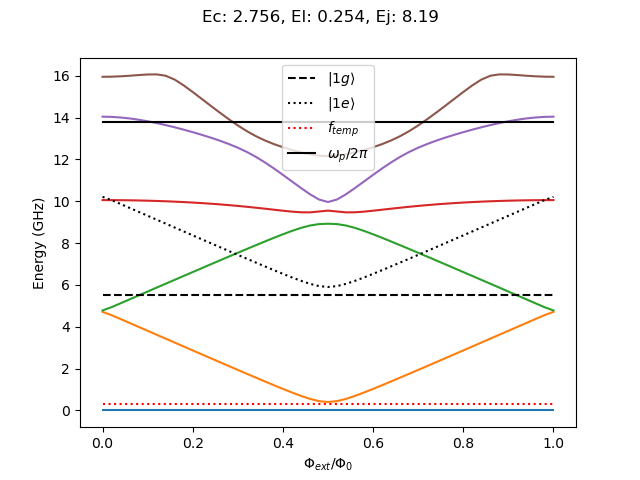

In [1137]:
%matplotlib widget
optimal.plot_evals_vs_flux(resonator_freq=5.5, plasma_freq=13.8)

Text(0.5, 0.98, 'Ec: 2.756, El: 0.254, Ej: 8.19, flux: 0.5')

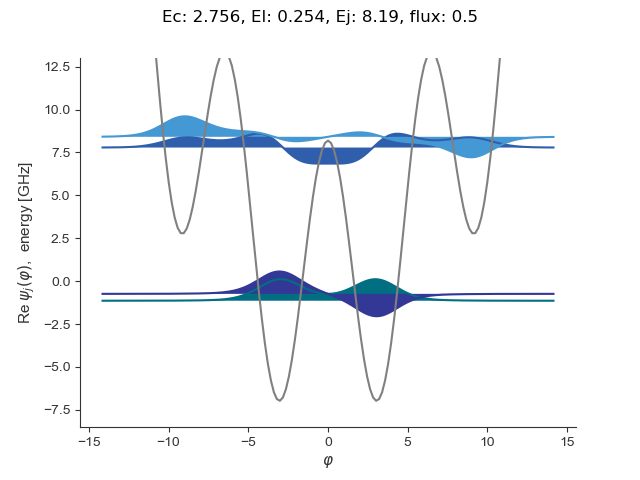

In [1138]:
fig, ax = fluxonium.plot_wavefunction([0,1,2,3])
fig.suptitle(f'Ec: {np.round(fluxonium.EC,3)}, El: {np.round(fluxonium.EL,3)}, Ej: {np.round(fluxonium.EJ,3)}, flux: {np.round(fluxonium.flux,2)}')

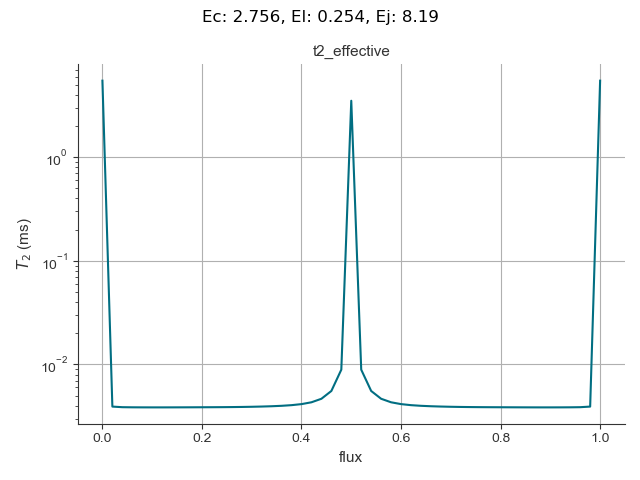

In [1139]:
# flux_array = np.linspace(-0.5, 0.5, 101)
fig, ax = fluxonium.plot_t2_effective_vs_paramvals(param_name='flux',
                                     param_vals=optimal.flux_array,
                                     noise_channels=['tphi_1_over_f_cc','tphi_1_over_f_flux',('t1_flux_bias_line', dict(M=1000)), 't1_inductive', ('t1_quasiparticle_tunneling', dict(Delta = 0.0002))],
                                     scale=1e-6
                                     )
fig.suptitle(f'Ec: {np.round(fluxonium.EC,3)}, El: {np.round(fluxonium.EL,3)}, Ej: {np.round(fluxonium.EJ,3)}')
ax.set_ylabel(r'$T_2$ (ms)')
fig.tight_layout()

# Fluxonium-resonator

In [1167]:
beta_list = np.linspace(0.001,0.15, 50)
chi_list_beta = np.zeros_like(beta_list)
for i, beta in enumerate(beta_list):
    fluxonium_resonator = optimal.fluxonium_resonator_creator(resonator_frequency=5.5, beta=beta)
    subst_eigvals = fluxonium_resonator.eigenvals(evals_count=4) - fluxonium_resonator.eigenvals()[0]
    chi_list_beta[i] = ((subst_eigvals[3]-subst_eigvals[1])-(subst_eigvals[2]-subst_eigvals[0]))*1e3

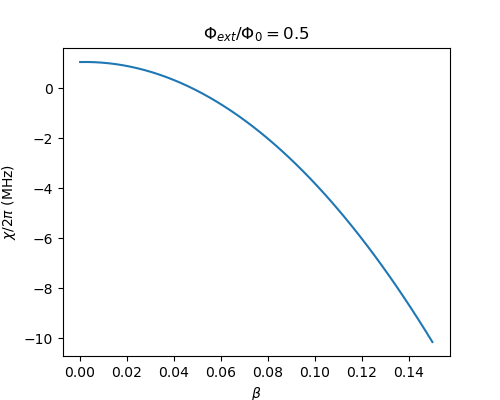

In [1169]:
plt.close('all')
fig,ax = plt.subplots(1,1, sharey=True, figsize = (5,4))
# ax[0].plot(resonator_freq_list,chi_list_res)
ax.set_title(rf'$\Phi_{{ext}}/\Phi_0 = 0.5$')
ax.plot(beta_list,chi_list_beta)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\chi/2\pi$ (MHz)')
# ax[2].plot(1/EL_res_list,chi_list_el)
plt.show()

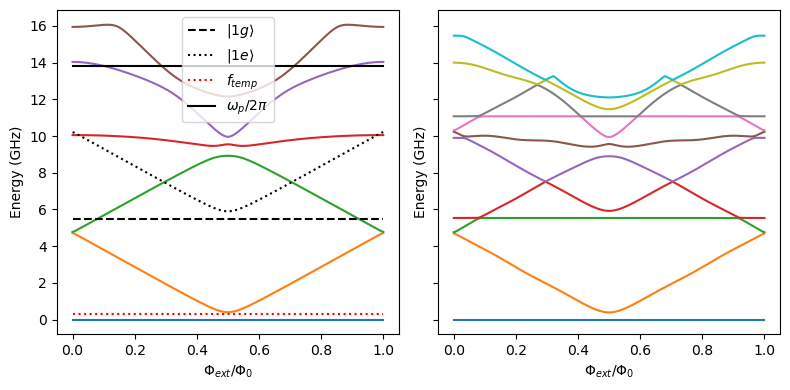

In [1191]:
optimal.flux_array = np.linspace(0,1, 301)
fig,ax = plt.subplots(1,2,sharey='row', figsize=(8,4))
optimal.plot_evals_vs_flux(resonator_freq=5.5,ax=ax[0], plasma_freq=13.8)
optimal.plot_evals_fluxonium_resonator_vs_flux(resonator_frequency=5.5,beta=0.10, evals_count=10, ax=ax[1])
fig.tight_layout()

In [1183]:
phi1_array = np.linspace(0,1,101)
fluxonium_resonator = optimal.fluxonium_resonator_creator(5.5, beta = 0.11)
eigensys_array = np.zeros((len(phi1_array),5))
for i, phi1 in enumerate(phi1_array):
    fluxonium_resonator.Φ1 = phi1
    eigvals = fluxonium_resonator.eigenvals(evals_count=5)
    eigensys_array[i] = eigvals

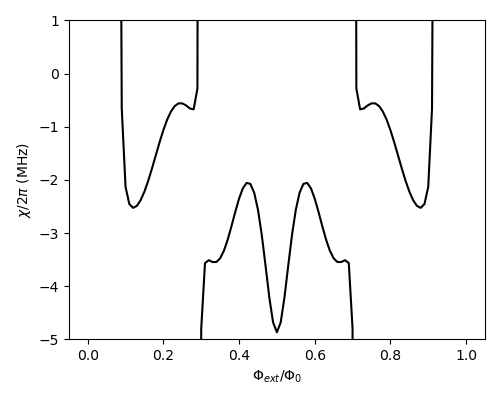

In [1186]:
plt.close('all')
%matplotlib widget
fig, ax = plt.subplots(1,1, figsize=(5,4))
# ax[0].plot(phi1_array,eigensys_array[:,1]-eigensys_array[:,0], label=r'$(E_{0e}-E_{0g})/h$')
# ax[0].plot(phi1_array,eigensys_array[:,5]-eigensys_array[:,0], label=r'$(E_{1g}-E_{0g})/h$')
ax.plot(phi1_array,1e3*((eigensys_array[:,3]-eigensys_array[:,1])-(eigensys_array[:,2]-eigensys_array[:,0])), color='k')
ax.plot(phi1_array,1e3*((eigensys_array[:,4]-eigensys_array[:,1])-(eigensys_array[:,2]-eigensys_array[:,0]))/2, color='k')
# ax.plot(phi1_array,1e3*((eigensys_array[:,5]-eigensys_array[:,1])-(eigensys_array[:,3]-eigensys_array[:,0]))/2, color='C0')

# ax[0].set_ylabel('Energy/h (GHz)')
# ax[0].set_xlabel(r'$\Phi_{ext}/\Phi_0$')
ax.set_xlabel(r'$\Phi_{ext}/\Phi_0$')
ax.set_ylabel(r'$\chi/2\pi$ (MHz)')
ax.set_ylim([-5,1])
# ax[0].legend()
fig.tight_layout()
plt.show()

# Fluxonium - Flux line

In [79]:
Phi0 = const.h/2/const.e
separation_array = np.linspace(15,25,10)
mutual_array = np.zeros_like(separation_array)
for i,separation in enumerate(tqdm(separation_array)):
    mutual_array[i] = calculate_mutual(loop_size=[12.4,63.6],
                    offset_position=[separation,13.2],
                    flux_line_length=90,
                    flux_line_width=7)/Phi0

  0%|          | 0/10 [00:00<?, ?it/s]

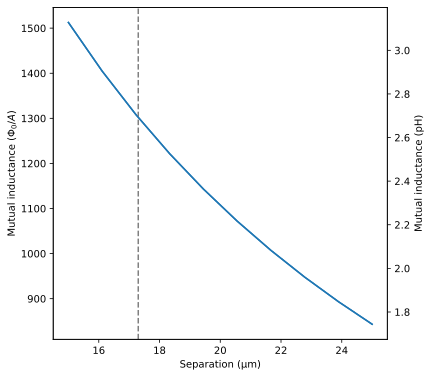

In [92]:
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(separation_array,mutual_array)
ax.set_xlabel('Separation (µm)')
ax.axvline(17.3, linestyle='dashed', color='gray')
ax.set_ylabel(r'Mutual inductance $(\Phi_0/A)$')

ax2 = ax.twinx()
# Trazar el segundo conjunto de datos en el eje Y derecho
ax2.plot(separation_array, mutual_array*Phi0*1e12)
ax2.set_ylabel('Mutual inductance (pH)')
plt.show()